# Unsupervised NLP Capstone
----

In [2]:
import numpy as np
import pandas as pd
import sklearn
import os
from sklearn.cluster import KMeans
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import glob
import requests 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg, stopwords
from collections import Counter
%matplotlib inline

In [3]:
english_stops = stopwords.words('english')
nlp = spacy.load('en')

### Training Set

In [4]:
path = "./data/20news-bydate/20news-bydate-train/"
df_news = pd.DataFrame(columns=['text', 'category'])

allGraphicsFiles = glob.glob(path + 'graphics' + "/*")
allWindowsMiscFiles = glob.glob(path + 'windows_misc' + "/*")
allPcHardwareFiles = glob.glob(path + 'pc_hardware' + "/*")
allMacHardwareFiles = glob.glob(path + 'mac_hardware' + "/*")
allWindowsXFiles = glob.glob(path + 'windows_x' + "/*")
allCryptFiles = glob.glob(path + 'crypt' + "/*")
allElectronicsFiles = glob.glob(path + 'electronics' + "/*")
allMedFiles = glob.glob(path + 'med' + "/*")
allSpaceFiles = glob.glob(path + 'space' + "/*")
allPoliticsFiles = glob.glob(path + 'politics' + "/*")

allFiles = (allGraphicsFiles + 
            allWindowsMiscFiles + 
            allPcHardwareFiles + 
            allMacHardwareFiles + 
            allWindowsXFiles + 
            allCryptFiles + 
            allElectronicsFiles + 
            allMedFiles + 
            allSpaceFiles + 
            allPoliticsFiles)

# for file_ in allFiles:
for idx, file_ in enumerate(allFiles):
    with open(file_, 'r', encoding='utf-8', errors='ignore') as myfile:
        data = myfile.read()
                
        # Grab label from the directory name
        labelFromDir = re.split(r'\/', allFiles[idx])[-2]     
        
        df_news = df_news.append({'text': data, 'category': labelFromDir}, ignore_index=True)

### Test set

In [5]:
path = "./data/20news-bydate/20news-bydate-test/"
df_news_test = pd.DataFrame(columns=['text', 'category'])

allGraphicsFiles = glob.glob(path + 'graphics' + "/*")
allWindowsMiscFiles = glob.glob(path + 'windows_misc' + "/*")
allPcHardwareFiles = glob.glob(path + 'pc_hardware' + "/*")
allMacHardwareFiles = glob.glob(path + 'mac_hardware' + "/*")
allWindowsXFiles = glob.glob(path + 'windows_x' + "/*")
allCryptFiles = glob.glob(path + 'crypt' + "/*")
allElectronicsFiles = glob.glob(path + 'electronics' + "/*")
allMedFiles = glob.glob(path + 'med' + "/*")
allSpaceFiles = glob.glob(path + 'space' + "/*")
allPoliticsFiles = glob.glob(path + 'politics' + "/*")

allTestFiles = (
            allGraphicsFiles + 
            allWindowsMiscFiles + 
            allPcHardwareFiles + 
            allMacHardwareFiles + 
            allWindowsXFiles + 
            allCryptFiles + 
            allElectronicsFiles +
            allMedFiles + 
            allSpaceFiles + 
            allPoliticsFiles)

# for file_ in allFiles:
for idx, file_ in enumerate(allTestFiles):
    with open(file_, 'r', encoding='utf-8', errors='ignore') as myfile:
        data = myfile.read() 
        
        # Grab label from the directory name
        labelFromDir = re.split(r'\/', allTestFiles[idx])[-2]
        
        df_news_test = df_news_test.append({'text': data, 'category': labelFromDir}, ignore_index=True)

In [6]:
# Train set
print(f'df_news.shape: {df_news.shape}')
df_news.head()

df_news.shape: (5774, 2)


,text,category
0,From: cavalier@blkbox.COM (Bill Egan)\nSubject...,graphics
1,From: ch381@cleveland.Freenet.Edu (James K. Bl...,graphics
2,From: rytg7@fel.tno.nl (Q. van Rijt)\nSubject:...,graphics
3,From: uk02183@nx10.mik.uky.edu (bryan k willia...,graphics
4,From: rschmitt@shearson.com (Robert Schmitt)\n...,graphics


In [7]:
df_news['category'].value_counts()

crypt           595
med             594
space           593
windows_x       593
electronics     591
windows_misc    591
pc_hardware     590
graphics        584
mac_hardware    578
politics        465
Name: category, dtype: int64

In [8]:
# Test set
print(f'df_news_test.shape: {df_news_test.shape}')
df_news_test.head()

df_news_test.shape: (3844, 2)


,text,category
0,From: Scott_Rindfleisch@vos.stratus.com\nSubje...,graphics
1,From: SITUNAYA@IBM3090.BHAM.AC.UK\nSubject: Be...,graphics
2,From: z_nixsp@ccsvax.sfasu.edu\nSubject: Re: T...,graphics
3,From: vax839@tid.es (Juan Carlos Cuesta Cuesta...,graphics
4,From: dts@buoy.cis.ufl.edu (Dave Small)\nSubje...,graphics


In [9]:
df_news_test['category'].value_counts()

med             396
crypt           396
windows_x       395
windows_misc    394
space           394
electronics     393
pc_hardware     392
graphics        389
mac_hardware    385
politics        310
Name: category, dtype: int64

## Preprocessing

In [10]:
def texter(text):
    # Remove special chars
    document = re.sub(r'\W', ' ', text)
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    tokens = [w for w in word_tokenize(document.lower()) 
                  if w.isalpha()]
    
    no_stops = [t for t in tokens 
                    if t not in english_stops]
    
    lemmatized = [WordNetLemmatizer().lemmatize(t) for t in no_stops]
    
    document = ' '.join(lemmatized)
    
    return document

In [11]:
# Before Preprocessing
df_news['text'][0]

"From: cavalier@blkbox.COM (Bill Egan)\nSubject: Re: Weitek P9000 ?\nNntp-Posting-Host: port3.houston.pub-ip.psi.net\nOrganization: Performance Systems Int'l\nLines: 13\n\njgreen@amber (Joe Green) writes:\n>> > Anyone know about the Weitek P9000 graphics chip?\n\n>Do you have Weitek's address/phone number?  I'd like to get some information\n>about this chip.\n\nYes, I am very interested in this chip.  Please follow up or email.\n\n--\nBill Egan          \nCavalier Graphics\nHouston, Texas\nEmail: cavalier@blkbox.com \n"

In [12]:
df_news['text'] = df_news['text'].apply(texter)
df_news_test['text'] = df_news_test['text'].apply(texter)

In [13]:
# After Preprocessing
df_news['text'][0]

'cavalier blkbox com bill egan subject weitek nntp posting host houston pub ip psi net organization performance system int line jgreen amber joe green writes anyone know weitek graphic chip weitek address phone number like get information chip yes interested chip please follow email bill egan cavalier graphic houston texas email cavalier blkbox com'

In [14]:
def mutlt_labels(row):
    if (row == 'crypt'):
        return 1
    elif (row == 'med'):
        return 2
    elif (row == 'windows_x'):
        return 3
    elif (row == 'space'):
        return 4
    elif (row == 'electronics'):
        return 5
    elif (row == 'windows_misc'):
        return 6
    elif (row == 'pc_hardware'):
        return 7
    elif (row == 'graphics'):
        return 8
    elif (row == 'mac_hardware'):
        return 9
    elif (row == 'politics'):
        return 10
    else:
        return row

In [15]:
df_news['category'] = df_news['category'].apply(mutlt_labels)
df_news_test['category'] = df_news_test['category'].apply(mutlt_labels)

In [17]:
df_news['category'].value_counts()

1     595
2     594
3     593
4     593
6     591
5     591
7     590
8     584
9     578
10    465
Name: category, dtype: int64

In [19]:
# X_test = df_news_test['text']
# y_test = df_news_test['category']
# count_test = count_vectorizer.transform(X_test.values)

## Train set split and BOW

In [22]:
# Create training and test sets
X_train, X_val, y_train, y_val = train_test_split(df_news['text'], df_news['category'], test_size=0.25,stratify=df_news['category'], random_state=53)

# Initialize a CountVectorizer, min appearance of 5 docs
count_vectorizer = CountVectorizer(stop_words="english", min_df=5)

# Transform the training data
count_train = count_vectorizer.fit_transform(X_train.values)

# Transform the val data
count_val = count_vectorizer.transform(X_val.values)

# Print the first 10 features
print(count_vectorizer.get_feature_names()[0:10])

['aa', 'aaron', 'aau', 'ab', 'abandon', 'abandoned', 'abc', 'abiding', 'ability', 'able']


In [23]:
# Test set
X_test = df_news_test['text']
y_test = df_news_test['category']
count_test = count_vectorizer.transform(X_test.values)

In [24]:
count_train.A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [25]:
print(f'count_train.shape: {count_train.shape}')
count_train.A

count_train.shape: (4330, 10252)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## TF-IDF

In [26]:
# Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=5)

# Transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train.values)

# Transform the validation data
tfidf_val = tfidf_vectorizer.transform(X_val.values)

# Transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test.values)

In [27]:
tfidf_train.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Clustering

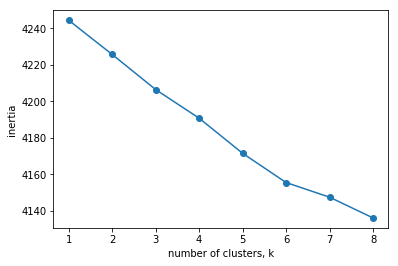

In [305]:
# Intertias
ks = range(1, 9)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tfidf_train)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

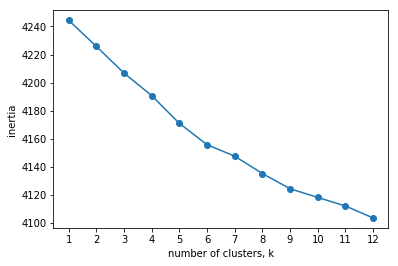

In [28]:
# Intertias
ks = range(1, 13)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tfidf_train)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

## Logistic Regression

In [300]:
# Instantiate
lr = LogisticRegression()

# Fit the classifier to the training data
lr.fit(count_train, y_train)

# Create the predicted tags: pred
pred = lr.predict(count_val)

print('Training set score:', lr.score(count_train, y_train))

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_val, pred)
print(f'\nTest set score: {score}')

# Calculate the confusion matrix: cm
pd.crosstab(y_val, pred)

Training set score: 1.0

Test set score: 0.8649584487534626


col_0,1,2,3,4,5,6,7,8,9,10
category,,,,,,,,,,
1,133,2,5,0,2,0,2,4,0,1
2,0,138,3,0,2,1,2,2,1,0
3,0,0,123,1,2,8,2,12,0,0
4,0,3,1,138,0,1,0,3,2,0
5,1,2,1,1,132,0,6,4,1,0
6,0,0,8,0,0,121,7,9,3,0
7,0,1,3,1,14,14,103,1,11,0
8,0,0,5,1,3,6,2,127,2,0
9,1,0,2,0,3,3,8,4,123,0


In [301]:
pred_test = lr.predict(count_test)

# Calculate the accuracy score: score
score_test = metrics.accuracy_score(y_test, pred_test)
print(f'\nTest set score: {score_test}')


Test set score: 0.782258064516129


In [302]:
# Calculate the confusion matrix: cm
pd.crosstab(y_test, pred_test)

col_0,1,2,3,4,5,6,7,8,9,10
category,,,,,,,,,,
1,355,2,4,1,6,3,3,6,7,9
2,1,326,7,3,16,3,12,10,6,12
3,2,2,275,5,12,32,15,45,6,1
4,0,7,3,352,11,3,1,11,4,2
5,5,8,2,2,291,12,32,18,21,2
6,4,7,21,1,4,270,32,30,19,6
7,2,0,11,0,27,29,273,17,30,3
8,7,7,21,4,20,17,15,285,12,1
9,1,1,5,0,14,11,33,6,313,1


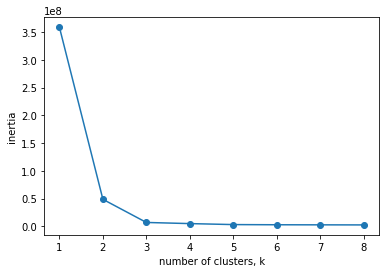

In [199]:
# Intertias
ks = range(1, 9)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(count_train)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

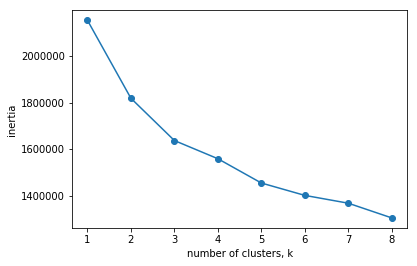

In [200]:
# Intertias
ks = range(1, 9)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(count_test)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [263]:
s = 'From: et@teal.csn.org (Eric H. Taylor)'
# lol = re.sub('^(.*From: )',"", s)
s = re.sub(r'(?m)^From:*\n?', '', s) 

In [264]:
s

' et@teal.csn.org (Eric H. Taylor)'

In [265]:
sep = 'From: '
rest = s.split(sep, 1)[0]

In [266]:
rest

' et@teal.csn.org (Eric H. Taylor)'